In [215]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [216]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [217]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [218]:
# Let's check I'm able to fetch Alpaca's keys
type(alpaca_api_key)

str

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame.

**As we want to forecast to 30 years I will use data for the last 5 years in order to estimate parameters**

In [219]:
# I will run each ticket seperately and then I will concat dataframes
# Set the tickers
ticker = ["AGG"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 2 year, between now and 365 days ago.
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
# Get 2 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AGG                                 
                             open    high     low   close   volume
time                                                              
2015-01-02 00:00:00-05:00  110.18  110.50  110.18  110.45  1766432
2015-01-05 00:00:00-05:00  110.56  110.76  110.48  110.67  3220575
2015-01-06 00:00:00-05:00  110.96  111.35  110.89  110.97  3089810
2015-01-07 00:00:00-05:00  111.00  111.04  110.74  110.92  3616860
2015-01-08 00:00:00-05:00  110.84  110.84  110.63  110.74  1873126

In [220]:
ticker = ["SPY"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 2 year, between now and 365 days ago.
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 2 year's worth of historical data for AAPL
df2 = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df2.head()

SPY                                    
                             open    high      low   close     volume
time                                                                 
2015-01-02 00:00:00-05:00  206.38  206.88  204.180  205.41   94506045
2015-01-05 00:00:00-05:00  204.17  204.37  201.350  201.80  133100354
2015-01-06 00:00:00-05:00  202.09  202.72  198.855  199.82  166955423
2015-01-07 00:00:00-05:00  201.42  202.72  200.880  202.34  103285826
2015-01-08 00:00:00-05:00  204.00  206.16  203.990  205.92  112316394

In [221]:
# We only need the close. Let's get rid of the rest
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)
df2 = df2.droplevel(axis=1, level=0)
df.rename(columns={'close' : 'AGG' }, inplace=True)
df2.rename(columns={'close' : 'SPY' }, inplace=True)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df2.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date
df2.index = df2.index.date

# concat the two dataframes
AGG_SPY_df = pd.concat([df,df2], axis = 'columns', join = 'inner')
AGG_SPY_df.tail(3)

,AGG,SPY
2019-12-27,112.62,322.86
2019-12-30,112.63,321.10
2019-12-31,112.37,321.92


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [222]:
# Calculate the daily roi for the stocks
Daily_returns_df = AGG_SPY_df.pct_change()
Daily_returns_df.dropna(inplace = True)
Daily_avg_returns_df = Daily_returns_df.mean() 
Daily_avg_returns_df

AGG    0.000016
SPY    0.000394
dtype: float64

In [223]:
# Calculate volatility
Daily_vol_df = Daily_returns_df.std()
Daily_vol_df

AGG    0.002027
SPY    0.008484
dtype: float64

In [224]:
# Save the last day's closing price
AGG_last_price = AGG_SPY_df['AGG'].iloc[-1]
SPY_last_price = AGG_SPY_df['SPY'].iloc[-1]
print(AGG_last_price)
print(SPY_last_price)

112.37
321.92


In [225]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [228]:
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [229]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_AGG_prices = [AGG_last_price]
    simulated_SPY_prices = [SPY_last_price]

    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(Daily_avg_returns_df['AGG'], Daily_vol_df['AGG']))
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(Daily_avg_returns_df['SPY'], Daily_vol_df['SPY']))
        
        # Append the simulated price to the list
        simulated_AGG_prices.append(simulated_AGG_price)
        simulated_SPY_prices.append(simulated_SPY_price)  
        
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% AGG; 40% SPY)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()        

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000302,0.999411,0.997878,1.003326,1.008589,0.996631,0.998919,1.008396,1.000447,0.996255,...,1.001326,0.993935,1.001819,1.001465,0.996825,1.002217,1.000241,1.003542,0.998730,0.995586
2,1.006427,1.002436,1.000725,0.996732,1.007067,0.994898,0.995664,1.002341,0.999490,0.995332,...,1.003783,0.995773,1.002888,1.003735,0.997314,0.993443,1.000562,1.002232,0.996896,0.998559
3,1.005508,1.001713,1.000922,0.996631,1.005310,0.990305,0.998589,0.997070,0.999065,1.001787,...,1.004094,0.991482,1.003663,1.006591,0.993122,0.994760,1.004503,0.998215,0.998705,1.001122
4,1.010226,1.003336,1.003340,1.000082,1.009233,0.991570,1.001536,0.992212,1.000983,1.003389,...,1.002149,0.993434,1.003499,1.002599,0.994629,0.993497,1.001576,1.000080,0.997723,1.001724


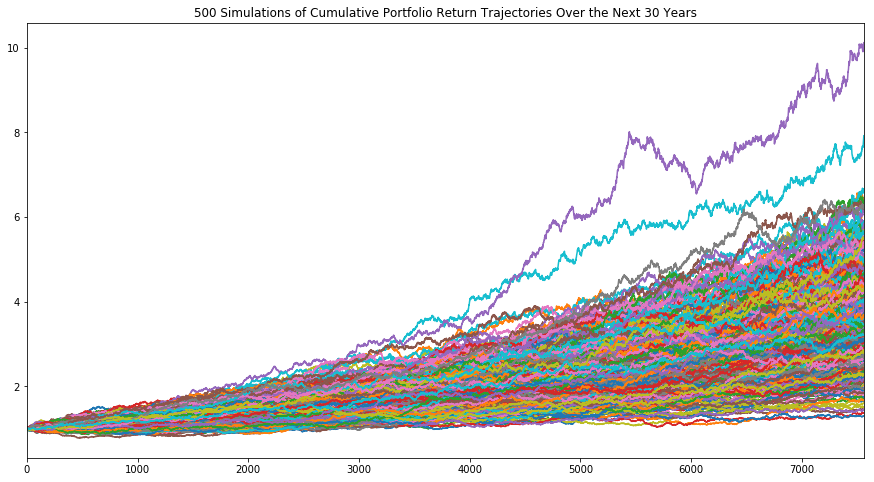

In [230]:
# Visualize the Simulation
# Use the `plot` function to plot `500` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize = (15,8))

In [251]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    3.397218
1    3.054634
2    3.266383
3    2.760084
4    3.214589
Name: 7560, dtype: float64

In [252]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
cumulative_returns_20Y = portfolio_cumulative_returns.iloc[-(252*10), :]
cumulative_returns_20Y.head()

0    2.201067
1    2.106908
2    1.897507
3    1.842377
4    2.907256
Name: 5041, dtype: float64

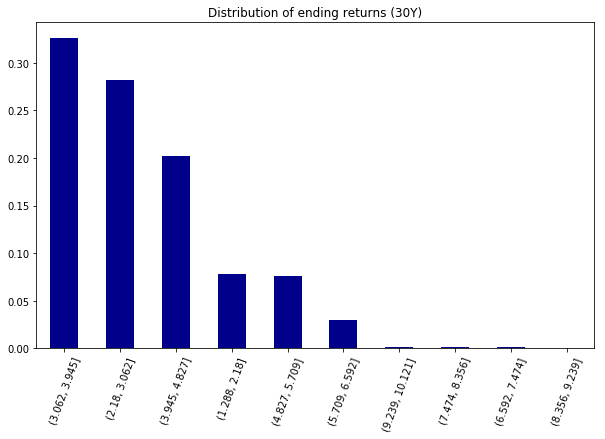

In [257]:
# Visualize the distribution of the ending returns
distribution_ending_returns = ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)
distribution_ending_returns.plot.bar(title = 'Distribution of ending returns (30Y)', rot = 70, color = 'DarkBlue', figsize = [10,6])

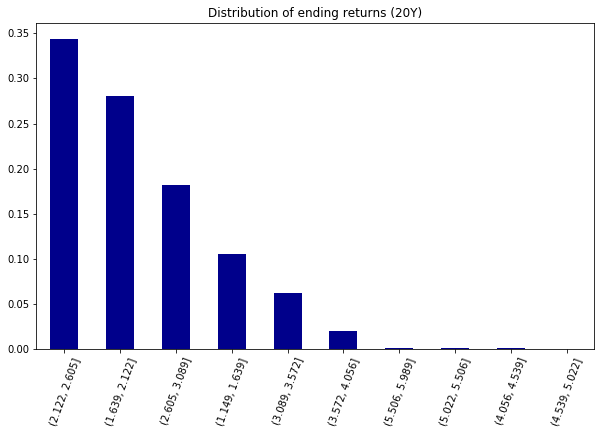

In [258]:
# Visualize the distribution of the returns after 20 years
distribution_returns_20Y = cumulative_returns_20Y.value_counts(bins=10) / len(ending_cumulative_returns)
distribution_returns_20Y.plot.bar(title = 'Distribution of ending returns (20Y)', rot = 70, color = 'DarkBlue', figsize = [10,6])

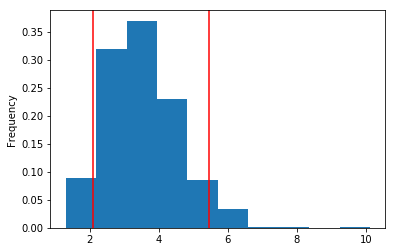

In [261]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [236]:
cum_return_30Y_10th = ending_cumulative_returns.quantile(q=[0.10])
cum_return_30Y_50th = ending_cumulative_returns.quantile(q=[0.50])
cum_return_30Y_90th = ending_cumulative_returns.quantile(q=[0.90])
print(f" The expected cumulative return at 30 years for the 10th percentile is: {cum_return_30Y_10th.iloc[0]}")
print(f" The expected cumulative return at 30 years for the 50th percentile is: {cum_return_30Y_50th.iloc[0]}")
print(f" The expected cumulative return at 30 years for the 90th percentile is: {cum_return_30Y_90th.iloc[0]}")

 The expected cumulative return at 30 years for the 10th percentile is: 2.2655749959352955
 The expected cumulative return at 30 years for the 50th percentile is: 3.408329303822989
 The expected cumulative return at 30 years for the 90th percentile is: 4.902706408442041


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [237]:
# expected return in dollars = ($20,000 * cumulative_return) - $20,000
print(f" The expected portfolio return at 30 years for the 10th percentile is: ${(20000* cum_return_30Y_10th.iloc[0]) - 20000}")
print(f" The expected portfolio return at 30 years for the 50th percentile is: ${(20000* cum_return_30Y_50th.iloc[0]) - 20000}")
print(f" The expected portfolio return at 30 years for the 90th percentile is: ${(20000* cum_return_30Y_90th.iloc[0]) - 20000}")

 The expected portfolio return at 30 years for the 10th percentile is: $25311.499918705907
 The expected portfolio return at 30 years for the 50th percentile is: $48166.58607645979
 The expected portfolio return at 30 years for the 90th percentile is: $78054.12816884082


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

I understand the question as this: *Can 4% of the retirement portfolio replace the annual income if we still want the retirement portfolio to growth to the current 10th percentile? I assume the interest rate is 0.*

From the Plaid analysis we have that the projected annual income is 7,389. Over the course of 30 years the total income would be (assuming interest rates are 0) 221,670. 

We need to withdraw 4% every year from the retirement portfolio. That number in Present-Value (PV) terms is:

In [249]:
PV = (1 + 0.04)**(-30)
print(PV)

0.3083186679734204


So the initial investment for the retirement portfolio would be reduced
to  (20,000 * 30.83%) = 6,166.37. 

We found above that the expected cumulative return at the 10th percentile is 2.26. The portfolio would grow to (6,166.37 * 2.26) = 13,937. This figure is very far away from the income that we would lose over the course of 30 years.

**Answer: A 4% withdraw rate in the retirement portfolio would not replace the projected annual income** 

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

A 50% increase in the initial investment is still not enough. The  retirement portfolio value after 30 years would be (30,000 * 2.26) = 67,800. This figure is still very far away from the 221,670 total projected income. To replace income over 30 years the initial investment amount would have to be at least (221,670 / 2.26) = 98,084.

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [293]:
# In order to do this we need to compute the median and quantiles 
# for each one of the 252 * 30 points of data

In [294]:
median_time_evolution = pd.DataFrame(portfolio_cumulative_returns.median(1))
percentiel_5_time_evolution =  portfolio_cumulative_returns.quantile(q=[0.05] , axis ='columns')
percentiel_95_time_evolution =  portfolio_cumulative_returns.quantile(q=[0.95], axis = 'columns')
# we need the transposes for the last two df
percentiel_5_time_evolution = percentiel_5_time_evolution.T
percentiel_95_time_evolution = percentiel_95_time_evolution.T

In [295]:
# concatenate into one single df
cum_returns_time_evol = pd.concat([median_time_evolution,percentiel_5_time_evolution,percentiel_95_time_evolution], axis = 'columns', join = 'inner')

In [296]:
# set up names of columns
cum_returns_time_evol.columns = ['median', '5% quantile', '95% quantile']
cum_returns_time_evol.tail(3)

,median,5% quantile,95% quantile
7558,3.401474,2.097571,5.469059
7559,3.402047,2.092910,5.460218
7560,3.408329,2.097050,5.465309


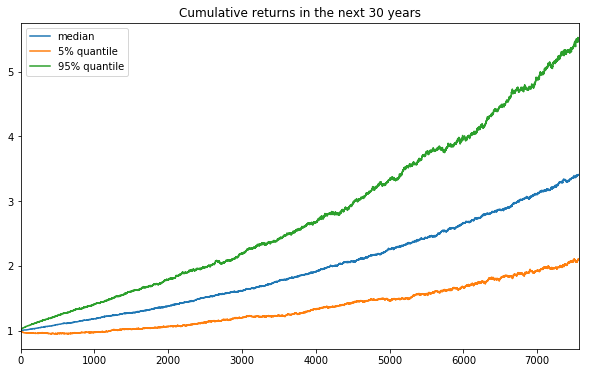

In [301]:
cum_returns_time_evol.plot(title = 'Cumulative returns in the next 30 years', figsize = [10,6])

___

## Optional Challenge — Early Retirement

Harold was really impressed with your work on this planner, but commented that 30 years seems like such a long time to wait to retire! Harold starts wondering if the retirement plan could be adjusted to retire earlier than normal. Try adjusting the portfolio to either include more risk (a higher stock than bond ratio) or to have a larger initial investment and rerun the retirement analysis to see what it would take to retire in five years instead of 30!

Let's use the median as the statistic we want to achieve after 30 years

In [274]:
# Use the drop function to drop 5% and 95% quantile
cum_returns_time_evol.drop(columns=['5% quantile', '95% quantile'], inplace=True)
cum_returns_time_evol.head()

,median
0,1.000000
1,1.000247
2,1.000344
3,1.000858
4,1.000775


In [288]:
# The cumulative return after five years is given at point (252 * 5) = 1260:
cum_return_5Y = cum_returns_time_evol.iloc[1259,0]
cum_return_5Y

1.2365231816599405

In [289]:
# the median cumulative return after 30 years is:
cum_return_30Y = cum_returns_time_evol.iloc[-1,0]
cum_return_30Y 

3.408329303822989

In [290]:
# to retire in 5y instead of 30y Harold would need to initially invest:
result = (cum_return_30Y / cum_return_5Y) * 20000
result 

55127.624849662105